In [2]:
from torch_snippets import *
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_dataset = datasets.MNIST(root='', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='', train=False, transform=transforms.ToTensor(), download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [3]:
train_dataset[0][0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder network
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.fc1 = nn.Linear(64 * 7 * 7, 256)
        self.fc21 = nn.Linear(256, 20)  # mu
        self.fc22 = nn.Linear(256, 20)  # logvar

        # Decoder network
        self.fc3 = nn.Linear(20, 256)
        self.fc4 = nn.Linear(256, 64 * 7 * 7)
        self.deconv1 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, padding=1, output_padding=1)

    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        mu = self.fc21(x)
        logvar = self.fc22(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = Variable(torch.randn(std.size()).cuda())
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        z = F.relu(self.fc3(z))
        z = F.relu(self.fc4(z))
        z = z.view(z.size(0), 64, 7, 7)
        z = F.relu(self.deconv1(z))
        z = torch.sigmoid(self.deconv2(z))
        return z

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        z = self.decode(z)
        return z, mu, logvar

In [5]:
def train_batch(data,model,optimizer,loss_function):
    model.train()
    data = data.to(device)
    optimizer.zero_grad()
    recon_batch, mean, log_var = model(data)
    loss,mse,kld = loss_function(recon_batch, data, mean, log_var)
    loss.backward()
    optimizer.step()
    return loss, mse, kld, log_var.mean(), mean.mean()

@torch.no_grad()
def validate_batch(data,model,loss_function):
    model.eval()
    data = data.to(device)
    recon,mean,log_var = model(data)
    loss, mse, kld = loss_function(recon,data,mean,log_var)
    return loss, mse, kld, log_var.mean(), mean.mean()

In [6]:
def loss_function(recon_x, x, mean, log_var):
    RECON = F.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1+log_var-mean.pow(2) - log_var.exp())
    return RECON + KLD, RECON, KLD

Epoch 1/10 -> Train Loss: 2866.1336 (Recon: 2527.0404, KLD: 339.0932) | Val Loss: 1970.3703 (Recon: 1424.2394, KLD: 546.1309)


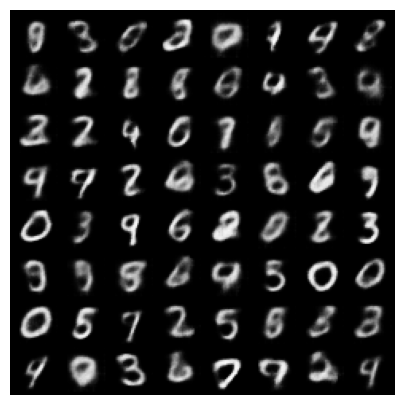

Epoch 2/10 -> Train Loss: 2073.7620 (Recon: 1475.5829, KLD: 598.1791) | Val Loss: 1740.0808 (Recon: 1084.8536, KLD: 655.2272)


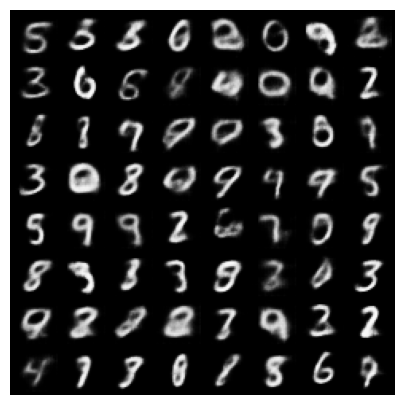

Epoch 3/10 -> Train Loss: 1963.5883 (Recon: 1314.5027, KLD: 649.0857) | Val Loss: 1668.9223 (Recon: 977.7107, KLD: 691.2116)


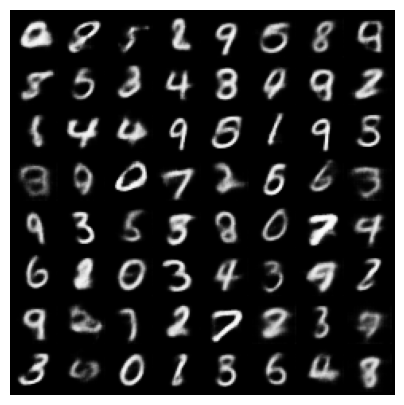

Epoch 4/10 -> Train Loss: 1916.1658 (Recon: 1242.8927, KLD: 673.2731) | Val Loss: 1601.8905 (Recon: 925.5184, KLD: 676.3721)


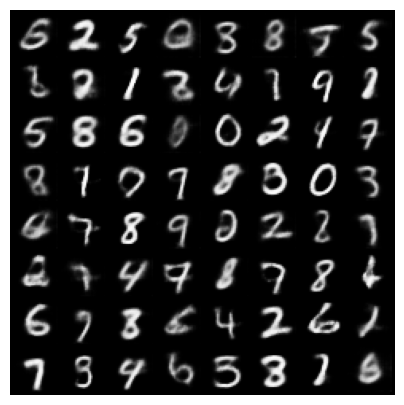

Epoch 5/10 -> Train Loss: 1879.8049 (Recon: 1188.3589, KLD: 691.4460) | Val Loss: 1577.5889 (Recon: 886.7583, KLD: 690.8307)


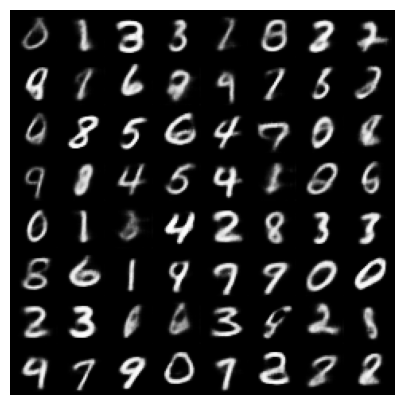

Epoch 6/10 -> Train Loss: 1856.4927 (Recon: 1154.0838, KLD: 702.4089) | Val Loss: 1549.7836 (Recon: 863.1086, KLD: 686.6751)


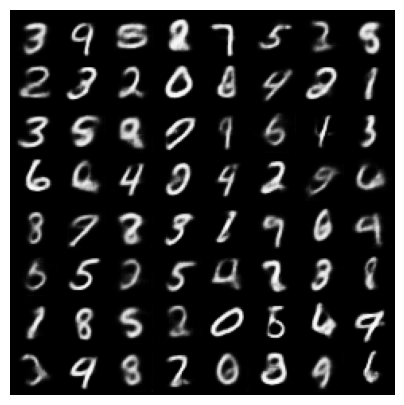

Epoch 7/10 -> Train Loss: 1839.9805 (Recon: 1130.1113, KLD: 709.8692) | Val Loss: 1538.3655 (Recon: 852.7875, KLD: 685.5780)


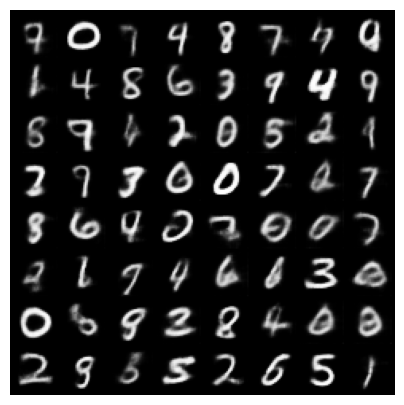

Epoch 8/10 -> Train Loss: 1827.5569 (Recon: 1111.6358, KLD: 715.9211) | Val Loss: 1514.6858 (Recon: 824.8558, KLD: 689.8299)


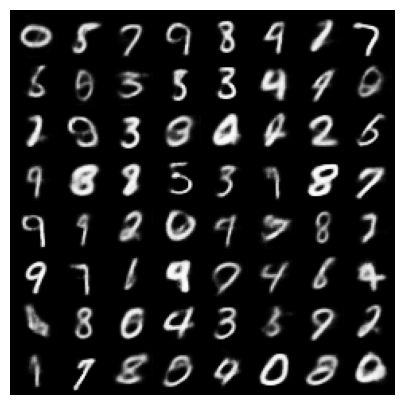

Epoch 9/10 -> Train Loss: 1814.7627 (Recon: 1091.5935, KLD: 723.1692) | Val Loss: 1523.9118 (Recon: 798.8957, KLD: 725.0161)


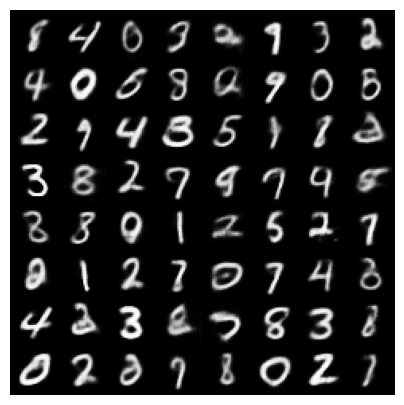

Epoch 10/10 -> Train Loss: 1802.9907 (Recon: 1072.5137, KLD: 730.4770) | Val Loss: 1506.9371 (Recon: 795.5954, KLD: 711.3417)


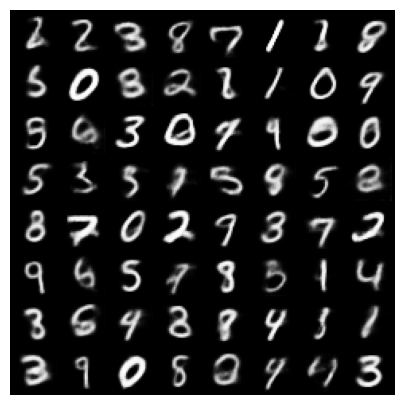

In [8]:
import torch
import torch.optim as optim
from torchvision.utils import make_grid

n_epochs = 10

history = {
    'train_loss': [], 'train_kld': [], 'train_recon': [],
    'val_loss': [], 'val_kld': [], 'val_recon': []
}


vae = VAE().to(device)
optimizer = optim.AdamW(vae.parameters(), lr=1e-3)

for epoch in range(n_epochs):
    for key in history:
        history[key].clear()

    vae.train()
    N = len(train_loader)
    for batch_idx, (data, _) in enumerate(train_loader):
        loss, recon, kld, log_var, mean = train_batch(data, vae, optimizer, loss_function)
        
        history['train_loss'].append(loss.item())
        history['train_kld'].append(kld.item())
        history['train_recon'].append(recon.item())
        
        print(f"Epoch {epoch+1}/{n_epochs} | Train Batch {batch_idx+1}/{N} | Loss: {loss.item():.4f}", end='\r')

    vae.eval()
    N = len(test_loader)
    for batch_idx, (data, _) in enumerate(test_loader):
        loss, recon, kld, log_var, mean = validate_batch(data, vae, loss_function)
        
        history['val_loss'].append(loss.item())
        history['val_kld'].append(kld.item())
        history['val_recon'].append(recon.item())


    avg_train_loss = sum(history['train_loss']) / len(history['train_loss'])
    avg_val_loss = sum(history['val_loss']) / len(history['val_loss'])
    avg_train_kld = sum(history['train_kld']) / len(history['train_kld'])
    avg_val_kld = sum(history['val_kld']) / len(history['val_kld'])
    avg_train_recon = sum(history['train_recon']) / len(history['train_recon'])
    avg_val_recon = sum(history['val_recon']) / len(history['val_recon'])

    print(" " * 80, end="\r") 
    print(f"Epoch {epoch+1}/{n_epochs} -> "
          f"Train Loss: {avg_train_loss:.4f} (Recon: {avg_train_recon:.4f}, KLD: {avg_train_kld:.4f}) | "
          f"Val Loss: {avg_val_loss:.4f} (Recon: {avg_val_recon:.4f}, KLD: {avg_val_kld:.4f})")


    with torch.no_grad():
        z = torch.randn(64, 20).to(device)
        sample = vae.decode(z).to(device)
        images = make_grid(sample.view(64, 1, 28, 28)).permute(1, 2, 0)
        show(images)